## Determining financial, situational and demographic factors affecting the health of an individual

### ISM6562.Big Data for Business - Group 2

#### Approach:

We had the following objectives when starting this project:

- Identifying a business problem that adds value in a real-time setting .
- Achieving efficiency in distributed (big data) processing during the whole project.
- Including the tools learnt in class to complete our analysis.

We initially discussed collecting live data, but owing to time and availability constraints, we restricted ourselves to data already available. We allocated a reasonable amount of time to identify a potential business problem and to collect its associated data - During this time we explored open data repositories such as data.gov, data.worldbank.org , dataverse.harvard.edu and also explored possibilities of scraping web data if we find a suitable problem for analysis. 

In this process, we came across this gem of a dataset [(consumerfinance.gov/data-research/financial-well-being-survey-data)](https://www.consumerfinance.gov/data-research/financial-well-being-survey-data/) : A public use file containing information on a survey conducted by the Consumer Financial Protection Bureau(CFPB) in 2016 to assess the financial well-being of people living in the United States. The survey is well conducted with a comprehensive coverage of audience from different backgrounds and demographics. The survey questionnaire is also very well-designed to ensure that an individual's exact financial state is captured along with relevant circumstances based on studies. This data seems to have been used in several studies and experiments, but with a wealth of information in it, there is so much more to extract from this data.

We took time to study each variable represented in this survey and CFPB's intent in capturing them. We also studied the response labels for each variable and designed our data pre-processing accordingly. The dataset(217 columns) can be categorized into the following sections for easier understanding:

- individual and household characteristics
- income, employment and saving characteristics
- financial experiences and behaviours

As a group, we looked into existing materials available on this dataset (as time allowed) and proposed several statistical and predictive analytics to be done on this data. We picked one which is most relevant and continued our analysis based on that proposal, which will be explained in the coming sections.

#### Objective:

The survey had some very interesting features - the individual's financial knowledge, their family situation, their financial preferences to name a few. One that caught our attention is the feature 'health'. This is the individual's general take on their personal health and they were allowed to pick one among 5 options (ranging from 1-Poor to 5-Excellent). The intent of CFPB behind capturing this field is to see if and how an individual's health affects their financial well-being and the extent of it. While this is a good assumption, there is also the possibility that a person's health can be affected by their current financial status and by some other factors that have been captured in this dataset. Some interesting ones that stood out to us are - 

- 'MATERIALISM' : How much a person values material things such as cars and social status
- 'CONNECT' : Psychological connectedness of a person to their environment
- 'MORTGAGE' and 'SAVINGS'
- 'FWB' : The person is ahead or behind with their finances

While these fields may show interesting patterns, there could be so many other financial factors in the 217 columns that contribute to the overall health of an individual. To get a better correlation and to make the distinction lines a bit more clear, we club the existing categories to form 2 final categories. 

- 1(Poor) and 2(Fair) will be clubbed into (0-Poor health)
- 3(Good), 4(Very Good), 5(Excellent) will be clubbed into (1-Good health)

#### Use of Technology:

The primary focus in our analysis was on achieving efficiency and scalability with processing - as is the intent of the ISM6562 course. While this data is not necessarily considered as 'big' in comparison to today's computing and storage systems' abilities, we ensured that this approach would work even if the data is scaled up. To achieve this we used specific technologies and made some assumptions which will be explained further.

- We picked RDD-based Apache Spark over Apache Hadoop MapReduce for parallel computation owing to its better performance in iterative jobs which we would need for our project.
- We will be working with a single-node cluster, but our analysis will assume operating on a multi-node cluster in all stages - the technicalities hidden by Spark's interface (We assume our program runs in the master node, and that the data is present in the data node) 
- To demonstrate our abilities in setting up and querying a distributed storage system, we plan to store our data in a Cassandra database before reading it into an RDD-based Spark Dataframe which is also distributed. (Cancelled)
- In the future, we also plan to add streaming and stream-processing systems such as Spark/Kafka Streaming, Flink etc. to demonstrate and strengthen our understanding of Big Data Systems and their integration.

<div>
<img src="https://drive.google.com/uc?export=view&id=1Z-iz0-FPZ2cNVZuej9cMqD8ii6S3LAxz" width="800" align="middle">
</div>

In [0]:
# Import required libraries

# data preprocessing
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler,OneHotEncoder, StringIndexer
from pyspark.sql.types import FloatType

# model building
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

# model evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [0]:
# Create SparkSQL data frame from existing csv files 
# (create directly on Cassandra?)

file_location = "/FileStore/tables/NFWBS_PUF_2016_data.csv"
file_type = "csv"
 
# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
 
fwb = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [0]:
# rows and columns
print((fwb.count(), len(fwb.columns)))

(6394, 217)


#### Data Pre-processing methodology

The survey codebook available at [files.consumerfinance.gov/documents/cfpb_nfwbs-puf-codebook.pdf](https://files.consumerfinance.gov/f/documents/cfpb_nfwbs-puf-codebook.pdf) gives a comprehensive overview of all the variables available in this dataset including the unique labels associated with each variable and their frequencies. We did an exhaustive study on all variables available in this dataset and developed strategies on how to deal with every single one of them. This was time-consuming but required, as it was important to know the purpose of every variable and its distribution, so as to engineer it in a way the model can understand.
Our pre-processing strategy includes the following steps:

  - Drop columns not required for the model
  - Drop rows which may contribute negatively to the learning
  - Impute missing values wherever necessary (multiple strategies according to column type)
  - Scale numerical columns
  - Encode categorical columns
  - Identify Target categories
  - Address any imbalance in data
  - Train - test split

#### Drop columns deemed unnecessary for predicting health
There were multiple columns which recorded user answer to inputs, but did not provide a context around those answers (that was done in a different variable) - so these are dropped. A few other ID columns are also dropped.

In [0]:
dropcols = ("PUF_ID","FINKNOWL1","FINKNOWL2","FINKNOWL3","KHKNOWL1","KHKNOWL2","KHKNOWL3","KHKNOWL4","KHKNOWL5","KHKNOWL6","KHKNOWL7","KHKNOWL8","KHKNOWL9","OBJNUMERACY1","finalwt")

fwb=fwb.drop(*dropcols)

In [0]:
print((fwb.count(), len(fwb.columns)))

(6394, 202)


#### Drop rows that may have a negative impact on prediction

Some columns have values that represent faulty / un-categorized entries in the survey. These values were either dropped / imputed

- (-ve)5 in PCTLT200FPL - County not known
- (-ve)4 in all columns - Database issues
- 8 in HSLOC - Could not recall living location
- (-ve)1 in all rows - Refused to answer (Tried to drop it first, but is imputed owing to high number of rows)

In [0]:
fwb = fwb.filter(col("PCTLT200FPL") != -5)
fwb = fwb.filter(col("HSLOC") != 8)

for col_name in fwb.columns:
    fwb = fwb.filter(col(col_name) != -4)

In [0]:
print((fwb.count(), len(fwb.columns)))

(5981, 202)


In [0]:
# -1 was recorded in many rows -  dropping it reduced the predictive power of the dataset

#for col_name in fwb.columns:
#    fwb = fwb.filter(col(col_name) != -1)

# Result rows and cols (3921, 202)
# this operation drops more than 2000 rows - which maybe good predictors. So it is better to impute -1 than drop

#### Use Impute strategies on certain other rows (since dropping may result in significant data loss)
We used the section 3.4 (Nonsubstantive value codes) to determine these values.

##### (-ve)1 in all columns will be imputed with most-occurring value of that column:
-1 occurred in entries requiring user inputs, which usually ranged from 1 to n. These values are considered categorical, so it is logical to impute -1 with the mode of that column.

##### - (-ve)2 in all columns will be imputed with most-occurring value of that column:
Similarly, -2 also occurred in entries requiring user inputs, which usually ranged from 1 to n. These values are considered categorical, so it is logical to impute -1 with the mode of that column.

##### - (-ve)3 in SOCSEC2, SOCSEC3 will be imputed with mean value of that column:
SOCSEC pertains to age when social security benefits were received / expected. So it is logical to impute -3 with the mean of this column.
##### - 98, 99 in HOUSERANGES, VALUERANGES, MORTGAGE, SAVINGSRANGES, EMPLOY  will be imputed with median value of that column:
All the above values were present in ranges, and we imputed them with the median value

In [0]:
imputer_neg1 = Imputer(
    inputCols=fwb.columns, 
    outputCols=fwb.columns,  
    strategy="mode",  
    missingValue=-1  
)

imputer_neg2 = Imputer(
    inputCols=fwb.columns, 
    outputCols=fwb.columns,  
    strategy="mode",  
    missingValue=-2  
)

In [0]:
cols_neg3impute = ['SOCSEC2', 'SOCSEC3']

imputer_neg3 = Imputer(
    inputCols=cols_neg3impute, 
    outputCols=cols_neg3impute,   
    strategy="mean",  
    missingValue=-3
)

cols_9899impute = ['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES', 'EMPLOY']

imputer_98 = Imputer(
    inputCols=cols_9899impute, 
    outputCols=cols_9899impute,  
    strategy="median",  
    missingValue=98
)

imputer_99 = Imputer(
    inputCols=cols_9899impute, 
    outputCols=cols_9899impute,  
    strategy="median",  
    missingValue=99
)

In [0]:
# impute operation is done in a pipeline
pipe_impute = Pipeline(stages=[imputer_neg1,imputer_neg2,imputer_neg3,imputer_98,imputer_99])
fit_model_impute=pipe_impute.fit(fwb)
fwb = fit_model_impute.transform(fwb)


In [0]:
print((fwb.count(), len(fwb.columns)))

(5981, 202)


In [0]:
# Verify if imputation worked
categories1 = [row[0] for row in fwb.select("SOCSEC2").distinct().collect()]
print(categories1)


categories2 = [row[0] for row in fwb.select("HOUSERANGES").distinct().collect()]
print(categories2)


[65, 64, 69, 63, 70, 62, 68, 66, 67]
[1, 6, 3, 5, 4, 7, 2]


####  Scale numerical columns

In [0]:
columns_to_scale = ['FWBscore','FSscore','LMscore','KHscore','CONNECT']
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline_scale = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline_scale.fit(fwb)
fwb = scalerModel.transform(fwb)

In [0]:
print((fwb.count(), len(fwb.columns)))

(5981, 212)


In [0]:
# drop original and assembler columns
dropcols_scale = ('FWBscore','FSscore','LMscore','KHscore','CONNECT','FWBscore_vec','FSscore_vec','LMscore_vec','KHscore_vec','CONNECT_vec')

fwb=fwb.drop(*dropcols_scale)

In [0]:
print((fwb.count(), len(fwb.columns)))

(5981, 202)


In [0]:
fwb.select('FWBscore_scaled').show(10)

+-------------------+
|    FWBscore_scaled|
+-------------------+
|[3.916330806512878]|
|[3.631506747857396]|
|[3.489094718529655]|
|[3.489094718529655]|
|[3.489094718529655]|
|[4.770802982479324]|
|[3.631506747857396]|
|[3.346682689201914]|
| [4.12994885050449]|
|  [5.5540691437819]|
+-------------------+
only showing top 10 rows



#### One-Hot Encode Nominal data

Most of the data present in the survey was *Ordinal*. They had some value associated with them, and neatly arranged starting from 1. So these did not need any pre-processing. However, there were still a few nominal fields without any value associated with them. So we apply One-Hot Encoding on these features.

In [0]:
ohe_cols = ['HOUSING','LIVINGARRANGEMENT','VOLATILITY','COVERCOSTS','HSLOC','DISCOUNT','EMPLOY','Military_Status','PPETHM','PPMARIT','PPREG4','PPREG9','sample']

ohe_stages = []

for ohe_col in ohe_cols:
    indexer = StringIndexer(inputCol=ohe_col, outputCol=ohe_col+'_index',handleInvalid='keep')
    encoder = OneHotEncoder(inputCol=ohe_col+'_index', outputCol=ohe_col+'_enc')
    ohe_stages += [indexer, encoder]
print(ohe_stages)
ohe_pipeline = Pipeline(stages=ohe_stages)
fwb = ohe_pipeline.fit(fwb).transform(fwb)


[StringIndexer_c555ce51c8ac, OneHotEncoder_1bf7aaacd2c0, StringIndexer_36f7b07d9fe6, OneHotEncoder_f63e7f0ec981, StringIndexer_945fef1ed21d, OneHotEncoder_c67c24f6b76d, StringIndexer_4b1008997596, OneHotEncoder_7de338aebd32, StringIndexer_82f630508cb5, OneHotEncoder_1aa4ff50962b, StringIndexer_0c89b45cc529, OneHotEncoder_c04c4f4e7e65, StringIndexer_ab724121ba1c, OneHotEncoder_88dfd4bf0e11, StringIndexer_e65cfea5315e, OneHotEncoder_47acfc150028, StringIndexer_8a1ca7cc5a3c, OneHotEncoder_e7eb4866df24, StringIndexer_306f71a315ae, OneHotEncoder_24930f71c425, StringIndexer_6089fb4c12ff, OneHotEncoder_267d7b88aab8, StringIndexer_9a9127c8e0b2, OneHotEncoder_390fdf8d4b5b, StringIndexer_dd2b24e460c6, OneHotEncoder_1760e7f4d459]


In [0]:
print((fwb.count(), len(fwb.columns)))

(5981, 228)


In [0]:
# drop original and indexer columns
dropcols_ohe = ('HOUSING','LIVINGARRANGEMENT','VOLATILITY','COVERCOSTS','HSLOC','DISCOUNT','EMPLOY','Military_Status','PPETHM','PPMARIT','PPREG4','PPREG9','sample','HOUSING_index','LIVINGARRANGEMENT_index','VOLATILITY_index','COVERCOSTS_index','HSLOC_index','DISCOUNT_index','EMPLOY_index','Military_Status_index','PPETHM_index','PPMARIT_index','PPREG4_index','PPREG9_index','sample_index')

fwb=fwb.drop(*dropcols_ohe)

In [0]:
print((fwb.count(), len(fwb.columns)))

(5981, 202)


In [0]:
#check if encoding works
fwb.select('HOUSING_enc').show(10)

+-------------+
|  HOUSING_enc|
+-------------+
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[1],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[2],[1.0])|
|(3,[0],[1.0])|
|(3,[1],[1.0])|
+-------------+
only showing top 10 rows



#### Combining Target categories and addressing imbalance

In [0]:
categories_count = fwb.select(["health"]).groupby(["health"]).count().sort(["health","count"],ascending=[True,False])
categories_count.show()

+------+-----+
|health|count|
+------+-----+
|     1|  142|
|     2|  716|
|     3| 1992|
|     4| 2483|
|     5|  648|
+------+-----+



#### Target Clubbing
We will combine 1&2(Poor,fair) into 1 category (0-Poor health), and also combine categories 3, 4, 5 (Good, Very Good, Excellent) into its own category(1-Good health)

In [0]:
fwb = fwb.withColumn("health", when(col("health") == 1, 0).otherwise(col("health")))
fwb = fwb.withColumn("health", when(col("health") == 2, 0).otherwise(col("health")))
fwb = fwb.withColumn("health", when(col("health") == 5, 1).otherwise(col("health")))
fwb = fwb.withColumn("health", when(col("health") == 4, 1).otherwise(col("health")))
fwb = fwb.withColumn("health", when(col("health") == 3, 1).otherwise(col("health")))

In [0]:
categories_count = fwb.select(["health"]).groupby(["health"]).count().sort(["health","count"],ascending=[True,False])
categories_count.show()

+------+-----+
|health|count|
+------+-----+
|     0|  858|
|     1| 5123|
+------+-----+



#### Performing Oversampling to handle data Imbalance
We observe significant imbalance among the target classes and it was critical to handle this as it could lead to models being biased towards the majority class, thus predicting the minority classes poorly. If the same class proportion is followed when the data is scaled up, this imbalance would be even more pronounced, making it important to handle this data imbalance to reduce any bias.

In [0]:
# oversample to fix target imbalance (revisit if required)

count_1 = fwb.where(col("health") == 0).count()
count_2 = fwb.where(col("health") == 1).count()

max_count = max(count_1, count_2)

sampled_fwb = (fwb.where(col("health") == 0)
                  .sample(withReplacement=True, fraction=max_count / count_1, seed=1) 
                  .union(fwb.where(col("health") == 1)
                        .sample(withReplacement=True, fraction=max_count / count_2, seed=1)))

In [0]:
categories_count = sampled_fwb.select(["health"]).groupby(["health"]).count().sort(["health","count"],ascending=[True,False])
categories_count.show()

+------+-----+
|health|count|
+------+-----+
|     0| 5037|
|     1| 5082|
+------+-----+



#### Train-Test Split (70-30)

In [0]:
train_data,test_data=sampled_fwb.randomSplit([0.7,0.3])

### Model building and Tuning

We picked 3 tree-based algorithms to train a classifier that predicts health. We are picking Tree models for easier interpretation of the output and to use their pre-existing feature_importance attribute.

In [0]:
# assembler
assembler = VectorAssembler(inputCols=[col for col in fwb.columns if col != 'health'], outputCol="features")

##### Decision Trees (Benchmark model)

In [0]:
# define and train
dt = DecisionTreeClassifier(labelCol="health")
pipe = Pipeline(stages=[assembler,dt])
fit_model=pipe.fit(train_data)
results = fit_model.transform(test_data)

In [0]:
# Area under Curve
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='health',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(results)
print("The area under the curve is {}".format(AUC))

The area under the curve is 0.7679519301626893


In [0]:
# Accuracy
ACC_evaluator = MulticlassClassificationEvaluator(
    labelCol="health", predictionCol="prediction", metricName="accuracy")
accuracy = ACC_evaluator.evaluate(results)
print("The accuracy of the model is {}".format(accuracy))

The accuracy of the model is 0.7676767676767676


In [0]:
# confusion matrix
predictionAndLabels = results.select(['prediction','health']).withColumn('health', col('health').cast(FloatType())).orderBy('prediction')
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
conf_matrix_dt = predictionAndLabels.crosstab("prediction", "health")
conf_matrix_dt = conf_matrix_dt.toPandas()
conf_matrix_dt.sort_values(by = ['prediction_health'])

,prediction_health,0.0,1.0
1,0.0,1193,408
0,1.0,282,1087


In [0]:
#calculate accuracy, sensitivity, specificity and precision
TP = conf_matrix_dt["1.0"][0]
FP = conf_matrix_dt["0.0"][0]
TN = conf_matrix_dt["0.0"][1]
FN = conf_matrix_dt["1.0"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.3f" %Accuracy )
print ("Sensitivity = %0.3f" %Sensitivity )
print ("Specificity = %0.3f" %Specificity )
print ("Precision = %0.3f" %Precision )

Accuracy = 0.768
Sensitivity = 0.727
Specificity = 0.809
Precision = 0.794


##### Random Forests

In [0]:
# define and train
rf = RandomForestClassifier(numTrees=10, maxDepth=10, seed=42, labelCol="health")
pipeline_rf = Pipeline(stages=[assembler, rf])
model = pipeline_rf.fit(train_data)
predictions = model.transform(test_data)

In [0]:
evaluator_auc1 = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='health', metricName='areaUnderROC')
auc = evaluator_auc1.evaluate(predictions)
print("The area under the curve is {}".format(auc))

The area under the curve is 0.9111433592199989


In [0]:
evaluator_acc_rf = MulticlassClassificationEvaluator(
    labelCol="health", predictionCol="prediction", metricName="accuracy") 
accuracy_rf = evaluator_acc_rf.evaluate(predictions)
print("The accuracy of the random forest model is {}".format(accuracy_rf))

The accuracy of the random forest model is 0.9111111111111111


In [0]:
# confusion matrix
predictionAndLabels = predictions.select(['prediction','health']).withColumn('health', col('health').cast(FloatType())).orderBy('prediction')
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
conf_matrix_rf = predictionAndLabels.crosstab("prediction", "health")
conf_matrix_rf = conf_matrix_rf.toPandas()
conf_matrix_rf.sort_values(by = ['prediction_health'])

,prediction_health,0.0,1.0
1,0.0,1351,140
0,1.0,124,1355


In [0]:
#calculate accuracy, sensitivity, specificity and precision
TP = conf_matrix_rf["1.0"][0]
FP = conf_matrix_rf["0.0"][0]
TN = conf_matrix_rf["0.0"][1]
FN = conf_matrix_rf["1.0"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.3f" %Accuracy )
print ("Sensitivity = %0.3f" %Sensitivity )
print ("Specificity = %0.3f" %Specificity )
print ("Precision = %0.3f" %Precision )

Accuracy = 0.911
Sensitivity = 0.906
Specificity = 0.916
Precision = 0.916


##### Gradient Boosted Trees

In [0]:
# define and train
gbt = GBTClassifier(labelCol="health", featuresCol="features")
pipeline_gb = Pipeline(stages=[assembler, gbt])
model_gb = pipeline_gb.fit(train_data)
predictions_gb = model_gb.transform(test_data)

In [0]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='health',metricName='areaUnderROC')
auc = evaluator.evaluate(predictions_gb)
print("The area under the curve is {}".format(auc))

The area under the curve is 0.8384445326228671


In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',labelCol='health',metricName='accuracy')
accuracy = evaluator.evaluate(predictions_gb)
print("The accuracy of the Gradient Boosted model is {}".format(accuracy))

The accuracy of the Gradient Boosted model is 0.8383838383838383


In [0]:
# confusion matrix
predictionAndLabels = predictions_gb.select(['prediction','health']).withColumn('health', col('health').cast(FloatType())).orderBy('prediction')
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:

conf_matrix_gb = predictionAndLabels.crosstab("prediction", "health")
conf_matrix_gb = conf_matrix_gb.toPandas()
conf_matrix_gb.sort_values(by = ['prediction_health'])

,prediction_health,0.0,1.0
1,0.0,1250,255
0,1.0,225,1240


In [0]:
#calculate accuracy, sensitivity, specificity and precision
TP = conf_matrix_gb["1.0"][0]
FP = conf_matrix_gb["0.0"][0]
TN = conf_matrix_gb["0.0"][1]
FN = conf_matrix_gb["1.0"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.3f" %Accuracy )
print ("Sensitivity = %0.3f" %Sensitivity )
print ("Specificity = %0.3f" %Specificity )
print ("Precision = %0.3f" %Precision )

Accuracy = 0.838
Sensitivity = 0.829
Specificity = 0.847
Precision = 0.846


#### Model Evaluation and Interpretation based on metrics

We have trained three tree-based models to predict an individual's health status. Out of the three models, the Random Forest model performs the best with an accuracy of 0.907, sensitivity of 0.896, specificity of 0.919, and precision of 0.921.

Accuracy: (TP+TN) / (TP+FP+TN+FN) = 0.907 Sensitivity (Recall): TP / (TP+FN) = 0.896 Specificity: TN / (TN+FP) = 0.919 Precision: TP / (TP+FP) = 0.921

Here, TP (True Positive) represents the number of correctly predicted 'Good health' instances, TN (True Negative) represents the number of correctly predicted 'Poor health' instances, FP (False Positive) represents the number of 'Poor health' instances incorrectly predicted as 'Good health', and FN (False Negative) represents the number of 'Good health' instances incorrectly predicted as 'Poor health'.

The high accuracy, sensitivity, specificity, and precision of the Random Forest model indicate that it performs well in predicting both 'Good health' and 'Poor health' instances. High sensitivity (0.896) means that the model is effective in identifying 'Good health' instances, whereas high specificity (0.919) shows the model's ability to correctly classify 'Poor health' instances. High precision (0.921) suggests that the model has a low rate of false positives, meaning it is effective in correctly predicting 'Good health' instances without misclassifying 'Poor health' instances.

An AUC score of 0.5 indicates a model that performs no better than random chance, and a score of 1 represents a perfect classifier. Here our Random Forest model has an AUC score of 0.91267, which is a strong indicator of the model's ability to differentiate between the two health categories (0-Poor health and 1-Good health). This high AUC score signifies that the model has a high probability of correctly classifying individuals into their respective health categories based on the given features.

In [0]:
# Get the feature importances of Random forest model
feature_importances = model.stages[-1].featureImportances
 
# Display feature importances along with feature names
# features will not increase with data-size, and should be okay to print all of them
for index, (feature, importance) in enumerate(zip(fwb.columns, feature_importances)):
    if index >= 10:
        break
    print(f"{feature}: {importance}")

fpl: 0.002349423046279152
SWB_1: 0.03694453069637997
SWB_2: 0.04071283813489432
SWB_3: 0.03148518809452324
FWB1_1: 0.007546234135420063
FWB1_2: 0.008278556991324706
FWB1_3: 0.013862678463036172
FWB1_4: 0.019495403254979532
FWB1_5: 0.004539319024808614
FWB1_6: 0.002619836254505415


In [0]:
# Combine feature names and importances into a list of tuples
feature_importance_tuples = list(zip(fwb.columns, feature_importances))
 
# Sort the list of tuples by importance (descending)
sorted_feature_importance_tuples = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)
 
# Display sorted feature importances
# features will not increase with data-size, and should be okay to print all of them
for index, (feature, importance) in enumerate(sorted_feature_importance_tuples):
    if index >= 10:
        break
    print(f"{feature}: {importance}")

SWB_2: 0.04071283813489432
SWB_1: 0.03694453069637997
BENEFITS_5: 0.032469337677964026
SWB_3: 0.03148518809452324
SELFCONTROL_2: 0.029995845286325075
OUTLOOK_1: 0.026219360355076323
SCFHORIZON: 0.023198147398143052
FWB2_2: 0.022688913340866434
SOCSEC3: 0.022024497607926966
GOALCONF: 0.02086171960741066


#### Visualizations
These visuals helped us better picture the important features - the visualizations were *created on a sample of the data*, so a very small portion of it is moved to the master node before using matplotlib.

Out[53]: [<matplotlib.lines.Line2D at 0x7f60450af0a0>]

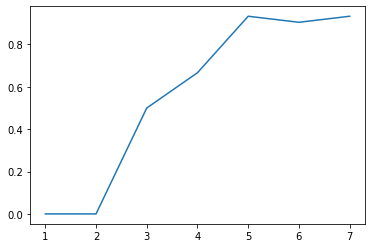

In [0]:
import matplotlib.pyplot as plt
# Extract a random sample of the data (1%)
sampled_df = fwb.sample(fraction=0.01, seed=42)

# Create a SparkSQL temporary view
sampled_df.createOrReplaceTempView("sampled_table")
 
# Query and group data by column SWB_2 and count occurrences
query = "SELECT SWB_2 , AVG(health) AS HealthAvg FROM sampled_table GROUP BY SWB_2 ORDER BY SWB_2"
result = spark.sql(query)

df_viz1 = result.toPandas()
plt.plot(df_viz1['SWB_2'],df_viz1['HealthAvg'])

Out[55]: [<matplotlib.lines.Line2D at 0x7f6044adb100>]

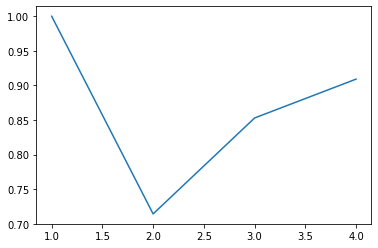

In [0]:
import matplotlib.pyplot as plt
# Extract a random sample of the data
sampled_df = fwb.sample(fraction=0.01, seed=42)

# Create a SparkSQL temporary view
sampled_df.createOrReplaceTempView("sampled_table")
 
# Query and group data by column SWB_2 and count occurrences
query = "SELECT SELFCONTROL_2 , AVG(health) AS HealthAvg FROM sampled_table GROUP BY SELFCONTROL_2 ORDER BY SELFCONTROL_2"
result = spark.sql(query)

df_viz1 = result.toPandas()
plt.plot(df_viz1['SELFCONTROL_2'],df_viz1['HealthAvg'])